Neighborhoods Clustering in Toronto

Installing all the required libraries and packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes
!conda install -c conda-forge beautifulsoup4 --yes #Installing BeautifulSoup
!conda install -c conda-forge lxml --yes  #Installing Parser library

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries Installed')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    sci

Utilizing 'Beautifulsoup' to scrape the 'Wikipedia webpage' and extract the table to convert to a Dataframe, for visualization and analysis

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content, features='html')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

In [85]:
#Printing the dataset: 
print(df.shape)
df.head()

(103, 3)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Drop rows where boroughs values are "Not assigned": 

In [4]:
df = df[df['Borough']!='Not assigned']
df[:10]

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
9,M9A,Downtown Toronto,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


Replacing "Not assigned" Neighborhoods with 'Borough' values:

In [5]:
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])

#Resetting the index values for the final dataframe: 
df= df.reset_index(drop=True)
df[:10]

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Queen's Park,Queen's Park
6,M9A,Downtown Toronto,Queen's Park
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


Combining neighbourhoods in same zip code into 1 data row:

In [83]:
df= df.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

print(df.shape)
df.head()

(103, 3)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Loading the 'CSV' file for obtaining 'Latitude' and 'Longitude' values of all 'zipcodes':

In [7]:
import csv
import os
file_path = '/resources/labs/DP0701EN/Geospatial_Coordinates.csv'
print(os.getcwd())
geo_coordinates = pd.read_csv(file_path)
geo_coordinates.head()

/resources/labs/DP0701EN


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the 2 tables on 'Postcode' to create latitude and longitude values for all 'Boroughs' and their respective 'Neighborhood': 

In [8]:
#Rename the 1st column of the dataframe as 'Postcode':
geo_coordinates = geo_coordinates.rename(columns ={"Postal Code": "Postcode"})

df = df.merge(geo_coordinates, on = 'Postcode')

df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Obtain the Latitude and Longitude of Toronto: 

In [9]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="foursquare_agent")

address = "Toronto, Ontario"
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

Create a visual map of Toronto and its neighbourhoods and corresponding Boroughs:

In [10]:
import folium
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

folium.CircleMarker(
        [latitude, longitude],
        popup = 'Toronto', 
        radius = 8,
        color = 'red',
        fill = True, 
        fill_color = 'red',
        opacity = 1.0).add_to(toronto_map)

for lat, long, neigh, boro in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Borough']):
    label = '{}; {}'.format(neigh, boro)
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker(
        [lat, long],
        popup = label, 
        radius = 4,
        color = 'blue',
        fill = True, 
        fill_color = 'blue',
        opacity = 0.4,
        parse_html = False).add_to(toronto_map)
    
toronto_map

Filtering out neighborhoods to include 'Boroughs' of Toronto only:

In [11]:
df_1 = []
df_1 = df[df['Borough'].str.contains('Toronto')].reset_index(drop = True)

df_1.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Creating the URL to explore venues around 'Toronto':


In [90]:
CLIENT_ID = '4U1D1Y4NBCWGRWG0AQ4OWDDCTYA13HNM3FRZBJIA3ES5ZN5Q' #Your Foursquare ID
CLIENT_SECRET = 'FPLOCTRVGFFZ5Q4X5GFNPAOPZ4SCWPVHEG2QNDSKFZJ22QYE' #Your Foursquare Secret
VERSION = '20191229' #Foursquare API Version
RADIUS = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT)

#url = 'https://api.foursquare.com/v2/venue/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,latitude,longitude,VERSION,RADIUS,LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=4U1D1Y4NBCWGRWG0AQ4OWDDCTYA13HNM3FRZBJIA3ES5ZN5Q&client_secret=FPLOCTRVGFFZ5Q4X5GFNPAOPZ4SCWPVHEG2QNDSKFZJ22QYE&ll=43.653963,-79.387207&v=20191229&radius=500&limit=100'

Caling the 'Get' method to load the json 

In [87]:
#Explore the neighborhoods in Toronto: 
json_data = requests.get(url).json()

#json_data

Extracting only the relevant items from the JSON file:

In [14]:
fin_results = json_data['response']['groups'][0]['items']
fin_results[1]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4f513029e4b07c3382c9fdb9',
  'name': 'Cafe Plenty',
  'location': {'address': '250 Dundas Street West',
   'crossStreet': 'Simcoe Street',
   'lat': 43.65457125894357,
   'lng': -79.38944976536852,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.65457125894357,
     'lng': -79.38944976536852}],
   'distance': 192,
   'postalCode': 'M5T 2Z5',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['250 Dundas Street West (Simcoe Street)',
    'Toronto ON M5T 2Z5',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d16d941735',
    'name': 'Café',
    'pluralName': 'Cafés',
    'shortName': 'Café',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referra

Create a function to extract categories of the venue:

In [15]:
#Explore the venues nearby the neighborhood:
def get_category_name(row):
    try:
        category_list = row['categories']
    except: 
        category_list = row['venue.categories']
        
    if len(category_list) == 0:
        return None
    else: 
        return category_list[0]['name']

Converting the JSON data into a Dataframe and finding the shape of the Dataframe:

In [16]:
results_df = json_normalize(fin_results)

results_df[:10]
results_df.shape

(78, 22)

Cleaning the Dataframe to include only relevant information:

In [17]:
results_df.head()

#Create a DataFrame of the filtered columns: 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

filtered_df = results_df.loc[:,filtered_columns]

#Extract the category "name" from the "venue.categories" column: 
filtered_df['venue.categories'] = filtered_df.apply(get_category_name, axis = 1)

#Filter the column names: 
filtered_df.columns = [col.split('.')[-1] for col in filtered_df.columns]

filtered_df.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Cafe Plenty,Café,43.654571,-79.389450
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Rolltation,Japanese Restaurant,43.654918,-79.387424
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


Testing the to see if there any neighborhoods with 0 venues around:

In [89]:
#lat = df_Toronto['Latitude'][1], long = df_Toronto['Longitude'][1]
lat = 43.99526
long = -79.341923
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, RADIUS, LIMIT)

results = requests.get(url).json()["response"]['groups'][0]['items']

results
len(results)

#df_Toronto.head() 

0

Creating a function to repeat the above for every neighborhood in the borough of "Toronto": 

In [101]:
def get_venue_names(neighborhood_name, latitude, longitude, RADIUS=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #create the API request URL:
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, RADIUS, LIMIT)
            
        #Make the GET request:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Return only relevant information for each nearby venue:
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results if len(results)!= 0])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood name', 
                  'Neighborhood latitude', 
                  'Neighborhood longitude', 
                  'Venue name',
                  'Venue category',
                  'Venue latitude', 
                  'Venue longitude']
    
    return(nearby_venues)

Calling the 'get_venue_names' function to list all the venues around ALL neighborhoods in boroughs of 'Toronto':

In [20]:
df_Toronto = df[df['Borough'].str.contains('Toronto')].reset_index(drop = True)

#Get nearby venues for all neighborhoods in 'Toronto':
toronto_venues = get_venue_names(neighborhood_name = df_Toronto['Neighborhood'], latitude = df_Toronto['Latitude'], 
                longitude = df_Toronto['Longitude'] ,RADIUS=500)

toronto_venues.shape

(1670, 7)

Grouping the venues for each neighborhood:

In [21]:
toronto_venues.groupby('Neighborhood name').count().reset_index(drop=False)

,Neighborhood name,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
0,"Adelaide, King, Richmond",100,100,100,100,100,100
1,Berczy Park,56,56,56,56,56,56
2,"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
3,Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",14,14,14,14,14,14
5,"Cabbagetown, St. James Town",45,45,45,45,45,45
6,Central Bay Street,84,84,84,84,84,84
7,"Chinatown, Grange Park, Kensington Market",90,90,90,90,90,90
8,Christie,17,17,17,17,17,17
9,Church and Wellesley,83,83,83,83,83,83


Counting number of unique venue categories: 

In [22]:
uniq_categories = len(toronto_venues['Venue category'].unique())

print('There are {} unique venue categories found in the borough of Toronto'.format(uniq_categories))

There are 233 unique venue categories found in the borough of Toronto


Analysing each of the neighborhoods in Toronto AND 'One-Hot-Encoding' all venue categories in 'Toronto', for each 'Neighborhood':

In [23]:
toronto_one_hot = pd.get_dummies(toronto_venues['Venue category'], prefix="", prefix_sep="")

toronto_one_hot['Neighborhood'] = toronto_venues['Neighborhood name']

#re-arranging the columns to have 'Neighborhood' as the 1st column:
fixed_columns = ['Neighborhood'] + list(toronto_one_hot.columns[:])

toronto_one_hot = toronto_one_hot[fixed_columns]

#Removing duplicate columns from the dataframe: 
toronto_one_hot = toronto_one_hot.loc[:,~toronto_one_hot.columns.duplicated()]

toronto_one_hot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Groupby using the 'Neighborhood' column find the mean for each of the 'venue categories' for each 'Neighborhood':

In [43]:
toronto_grouped_neighborhood = toronto_one_hot.groupby('Neighborhood').mean().reset_index()

toronto_grouped_neighborhood.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,0.0000,0.000000,0.000000,0.000000,0.030000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.010000,0.000000,0.000000,0.01,0.030000,0.010000,0.000000,0.000000,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.020000,0.00000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000

Exploring the shape of the 'aggregated' and grouped Neighborhoods of Toronto:

In [25]:
toronto_grouped_neighborhood.shape

(38, 233)

Creating a function to return the 'n' most common venues for each of the neighborhoods in Toronto:

In [26]:
def find_most_common_venues(row, num_top_ven):
    venue_categories = row.iloc[1:]
    venue_categories_sorted = venue_categories.sort_values(ascending=False)
    
    return venue_categories_sorted.index.values[0:num_top_ven]    
    

Calling the above function (of common venues in each 'Neighborhood') and storing it a newly created Dataframe called "toronto_sorted_neigh":

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create the 11 columns of the Dataframe: 
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#Create the Pandas DataFrame: 
toronto_sorted_neigh = pd.DataFrame(columns = columns)
toronto_sorted_neigh['Neighborhood'] = toronto_grouped_neighborhood['Neighborhood']

#Sort the 10 most common venues per neighborhood in descending order, in the created Dataframe:
for i in np.arange(toronto_grouped_neighborhood.shape[0]):
    toronto_sorted_neigh.iloc[i,1:] = find_most_common_venues(toronto_grouped_neighborhood.iloc[i,:], num_top_venues)
    
print(toronto_sorted_neigh.shape)
toronto_sorted_neigh.head()

(38, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Bakery,Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Farmers Market,Beer Bar,Steakhouse,Seafood Restaurant,Grocery Store
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Yoga Studio,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport,Airport Food Court,Airport Lounge,Harbor / Marina,Bar,Sculpture Garden,Boutique,Boat or Ferry
5,"Cabbagetown, St. James Town",Coffee Shop,Park,Restaurant,Café,Italian Restaurant,Pub,Bakery,Pizza Place,Pet Store,Sandwich Place
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Ice Cream Shop,Sandwich Place,Burger Joint,Gym / Fitness Center,Middle Eastern Restaurant,Juice Bar,Japanese Restaurant
7,"Chinatown, Grange Park, Kensington Market",Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Café,Bar,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Bakery,Mexican Restaurant,Cocktail Bar
8,Christie,Café,Grocery Store,Park,Nightclub,Italian Restaurant,Candy Store,Restaurant,Diner,Athletics & Sports,Baby Store
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym


Determinig optimal number of clusters using the "WSS" and "Silhouette" methods and plotting the respective results: 

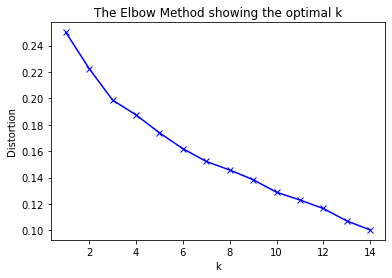

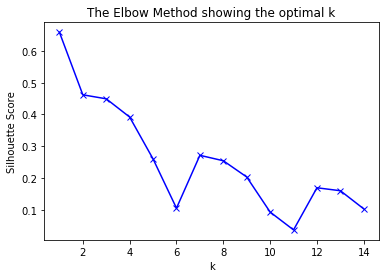

In [78]:
#Determinig optimal number of clusters using the WSS method: 
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# create new plot and data
plt.plot()
X = toronto_grouped_clustering# np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(np.sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

###########################################################################################################################################
#Determing Optimal number of clusters using the Silhouette method:
from sklearn.metrics import silhouette_score

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method showing the optimal k')
plt.show()

1. Using a cluster size of 'n', per the results from the above 2 graphs/methods:
2. Calling the "KMeans" clustering algorithm to fit the data in the model and displaying the resulting labels: 

In [94]:
#Implemneting the 'K-Means Clustering' algorithm on the Toronto dataset:
from sklearn.cluster import KMeans
k_cluster = 3

toronto_grouped_clustering = toronto_grouped_neighborhood.drop(columns = ['Neighborhood'], axis = 1)

KCluster = KMeans(n_clusters = k_cluster, random_state = 0).fit(toronto_grouped_clustering)

KCluster.labels_[:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Merging the dataframes to label each of the neighborhoods into their respective clusters:

In [96]:
#Merge the cluster labels to the Toronto data set:
#toronto_sorted_neigh = toronto_sorted_neigh.drop('Clusters', axis=1)
toronto_sorted_neigh.insert(0,'Clusters', KCluster.labels_)
merged_toronto_venues = df_Toronto

#print(merged_toronto_venues[-5:])
merged_toronto_venues = merged_toronto_venues.rename(columns = {'Neighborhood name':'Neighborhood'})

merged_toronto_venues = merged_toronto_venues.merge(toronto_sorted_neigh, on='Neighborhood')
print(merged_toronto_venues.shape)
merged_toronto_venues.head()        

(38, 16)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Other Great Outdoors,Pizza Place,Health Food Store,Coffee Shop,Trail,Yoga Studio,Diner,Discount Store,Dog Run
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Furniture / Home Store,Italian Restaurant,Bookstore,Restaurant,Diner,Pub,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Sandwich Place,Park,Brewery,Movie Theater,Pub,Food & Drink Shop,Ice Cream Shop,Fast Food Restaurant,Italian Restaurant,Board Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Gastropub,Yoga Studio,Diner,Pet Store,Park
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store


Creating a map to visualize the 'Clusters' of neighborhoods in Toronto which are similar one another based on types of venues located in each of the neighborhoods:

In [102]:
#Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters:
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(merged_toronto_venues['Latitude'], merged_toronto_venues['Longitude'], merged_toronto_venues['Neighborhood'], merged_toronto_venues['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

AttributeError: 'list' object has no attribute 'rgb2hex'